In [1]:
## Requerimientos
## tf.__version__ que sea 2.6.2

# !pip  install transformers==4.5.1 -q

# CUDA
# Cuda compilation tools, release 11.2, V11.2.67
# Build cuda_11.2.r11.2/compiler.29373293_0

In [42]:
import transformers

In [43]:
import tensorflow as tf
import keras
import pandas as pd
import json
import gc

import numpy as np

from tqdm import tqdm

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers.utils import logging

#from transformers import TextClassificationPipeline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
    
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot



Cerciorarse que estemos usando el GPU, debemos tener cuda instalado

In [44]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Ubicarse en el lugar donde se tenga la data

In [46]:
cd F:\Maestria\TESIS\

F:\Maestria\TESIS


In [47]:
df= pd.read_csv('./BD_POL/cleansed_df.csv', encoding='iso-8859-1')
df.head()

,bias,text,count,lemmatized_text
0,1,nowthisnews rep trey radel r fl slams obamaca...,9,nowthisnews rep trey radel r fl slam obamacare...
1,1,video obamacare full of higher costs and bro...,9,video obamacare full of higher cost and broken...
2,0,please join me today in remembering our fallen...,22,please join me today in remembering our fallen...
3,0,senatorleahy 1st step toward senate debate on...,19,senatorleahy 1st step toward senate debate on ...
4,1,amazon delivery drones show need to update law...,19,amazon delivery drone show need to update law ...


In [48]:
df.shape

(4823, 4)

In [49]:
df.head(2)

,bias,text,count,lemmatized_text
0,1,nowthisnews rep trey radel r fl slams obamaca...,9,nowthisnews rep trey radel r fl slam obamacare...
1,1,video obamacare full of higher costs and bro...,9,video obamacare full of higher cost and broken...


#### Reducimos un poco la clase mayoritaria

In [50]:
# df_w.sort_values("bias", inplace=True)
# df_w = df_w.reset_index(drop=True)

In [51]:
### Dropeamos varias ROWS con CLASE = NEUTRA, para emparejar
# df_w = df_w.iloc[500:,:]

In [52]:
# plt.figure(figsize= (8, 8))

# sns.displot(df_w['bias'])
# #df_w.bias.value_counts().plot(kind='pie', figsize=(5,5))
# plt.show()

Ahora son menos, y las clases son más parejas

In [53]:
# SHUFFLING el dataset
df_w = df.sample(frac=1, random_state = 1).reset_index(drop=True)

In [54]:
df_w = df_w[["lemmatized_text","bias","count"]]

In [55]:
df_w.tail()

,lemmatized_text,bias,count
4818,hope yall will join me tonight a we discus the...,0,47
4819,it is unacceptable that we have 4 million jobl...,1,22
4820,small nonfarm business in 43 colorado county a...,1,16
4821,met with egyptian ambassador to the u mohamed ...,0,22
4822,a great lunch at hotel congress in tucson one ...,0,16


In [56]:
df_w.describe()

,bias,count
count,4823.000000,4823.000000
mean,0.260211,26.971180
std,0.438795,20.989031
min,0.000000,3.000000
25%,0.000000,15.000000
50%,0.000000,19.000000
75%,1.000000,30.000000
max,1.000000,125.000000


In [57]:
df_w.dtypes

lemmatized_text    object
bias                int64
count               int64
dtype: object

In [58]:
## Botamos las rows que tengan demasiadas palabras que llenan la memoria.
# df_w.drop(df_w[(df_w['count'] >100)].index, inplace=True)

In [59]:
# df_w.describe()

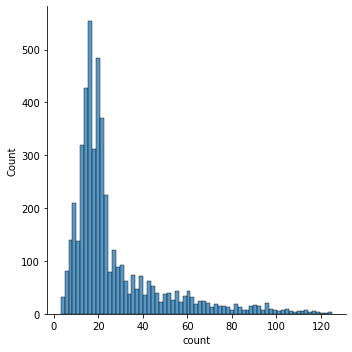

In [60]:
sns.displot(df_w['count'])

### Transformamos a listas para tokenizar

In [61]:
data_texts = df_w['lemmatized_text'].to_list()

data_labels = df_w['bias'].to_list()

In [62]:
len(data_labels)

4823

In [63]:
df_w.shape

(4823, 3)

### Train Test Split

In [64]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts,
                                                                    data_labels,
                                                                    test_size = 0.2,
                                                                    #random_state = 0, ) ## Shuffle
                                                                    stratify = data_labels)

val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts,
                                                                  val_labels,
                                                                  test_size = 0.4,
                                                                  #random_state = 0, ) ## Shuffle del dS
                                                                  stratify = val_labels )

## TOKENIZAR

In [65]:
## Usamos DISTILBERT para tokenizar el DS
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## Tokenizamos los Datasets
train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

test_encodings = tokenizer(test_texts, truncation = True, padding = True )

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\CLIENTE/.cache\huggingface\transformers\0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\CLIENTE/.cache\huggingface\transformers\8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.76ea01b4b85ac16e2cec55c398cba7a943d89ab21dfdd973f6630a152e4b9aed
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\CLIENTE/.cache\huggingface\transformers\75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e

#### Convertimos a tensores

In [66]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

### Hacemos el Fine-tuning con el TFTrainer class

In [67]:
from transformers import TFTrainer, TFTrainingArguments

https://discuss.huggingface.co/t/import-error-while-loading-a-fine-tuned-distilbert-model/28615

### Argumentos del TRAINING

In [68]:

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    max_steps = 400,  # --- > Si no colocamos 400 steps, da error con el "lr_scheduler"
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=1e-4,
    logging_dir='./logs',
    eval_steps=25, 
    learning_rate = 0.005,
    lr_scheduler_type = "constant_with_warmup",
    #no_cuda = False
)

# max_steps = 500, Da error

The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [69]:
transformers.TFTrainingArguments.device

In [70]:
import tensorflow as tf
from tensorflow.compat.v1 import RunOptions

run_options = RunOptions(report_tensor_allocations_upon_oom=True)

In [71]:
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                                          num_labels = 2 )
    #trainer_model.compile(loss = "...", optimizer = "...", metrics = "..", options = run_opts)

Tensorflow: setting up strategy
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\CLIENTE/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.5.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/tf_model.h5 from cache at C:\Users\CLIENTE/.cache\huggingface\transformers\fa107dc22c01

In [72]:
trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,    
)

You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.
To use comet_ml logging, run `pip/conda install comet_ml` see https://www.comet.ml/docs/python-sdk/huggingface/


In [73]:
trainer.optimizer = tf.keras.optimizers.SGD()

In [74]:
logging.set_verbosity_info()
logger = logging.get_logger("transformers")
logger.info("INFO")
logger.warning("WARN")

INFO
WARN


### ENTRENAR

In [75]:
trainer.train()

# Toma 3 min 36 secs hacer el training
# Toma 40sec con el GPU 4070super
## SI ESTA USANDO EL GPU

***** Running training *****
  Num examples = 3858
  Num Epochs = 2.0
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Steps per epoch = 242
  Total optimization steps = 400


Training took: 0:00:34.499410


In [76]:
# Evaluamos
# Eval_loss sale bastante grande
trainer.evaluate()

***** Running Evaluation *****
  Num examples in dataset = 579
  Num examples in used in evaluation = 608
  Batch size = 32


{'eval_loss': 0.41515761927554484, 'epoch': 1.6528925619834711, 'step': 400}


{'eval_loss': 0.41515761927554484}

In [77]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples in dataset = 386
  Batch size = 32


PredictionOutput(predictions=array([[-0.1819347 ,  0.30811238],
       [-0.10774019,  0.29780862],
       [ 0.8244981 , -0.890223  ],
       [ 1.2265089 , -1.397812  ],
       [ 1.4130007 , -1.6571804 ],
       [ 0.54375833, -0.62150365],
       [ 0.9880867 , -1.1148845 ],
       [ 1.5664463 , -1.8046014 ],
       [ 0.9711989 , -1.1744199 ],
       [ 0.91022485, -1.0511023 ],
       [ 0.7842584 , -0.8531886 ],
       [ 1.5253234 , -1.7604742 ],
       [ 0.65812254, -0.72661394],
       [-0.27595904,  0.45868966],
       [ 0.828103  , -0.9215972 ],
       [ 1.521909  , -1.7506713 ],
       [ 0.6669788 , -0.6922987 ],
       [-0.14454144,  0.24864744],
       [ 1.4602367 , -1.601759  ],
       [ 1.2034502 , -1.3062446 ],
       [ 0.52004373, -0.49782884],
       [-0.35383174,  0.60779464],
       [ 1.1783348 , -1.2977145 ],
       [ 0.42609042, -0.39385903],
       [ 0.7542749 , -0.86666644],
       [ 1.3934033 , -1.4972862 ],
       [-0.10699167,  0.23319636],
       [-0.36758032,  0.52

In [78]:
results_test = trainer.predict(test_dataset)

prediction_value = tf.argmax(results_test.predictions, axis = 1).numpy()
prediction_value

***** Running Prediction *****
  Num examples in dataset = 386
  Batch size = 32


array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[[242  44]
 [ 49  51]]


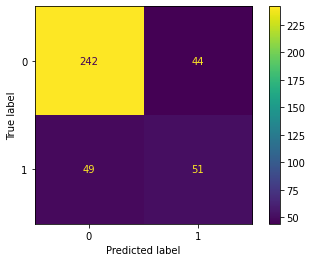

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

# Create a confusion matrix
conf_mat = confusion_matrix(test_labels, prediction_value)

# Print the confusion matrix
print(conf_mat)

confusion_matrix = confusion_matrix(test_labels, prediction_value)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(test_labels, prediction_value)
precision = precision_score(test_labels, prediction_value, average='macro')
recall = recall_score(test_labels, prediction_value, average='macro')
f1 = f1_score(test_labels, prediction_value, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.759
Precision: 0.684
Recall: 0.678
F1 score: 0.681


In [41]:
### CON TEXTS LEMATIZADOS
# Accuracy: 0.816
# Precision: 0.769
# Recall: 0.720
# F1 score: 0.738

# Accuracy: 0.759
# Precision: 0.684
# Recall: 0.678
# F1 score: 0.681

# Accuracy: 0.772
# Precision: 0.701
# Recall: 0.690
# F1 score: 0.695

# Accuracy: 0.759
# Precision: 0.684
# Recall: 0.678
# F1 score: 0.681




### CON TEXTS SIN LEMATIZAR
# Accuracy: 0.790
# Precision: 0.739
# Recall: 0.657
# F1 score: 0.676

# Accuracy: 0.764
# Precision: 0.690
# Recall: 0.678
# F1 score: 0.683

# Accuracy: 0.780
# Precision: 0.716
# Recall: 0.728
# F1 score: 0.721

# Accuracy: 0.764
# Precision: 0.690
# Recall: 0.678
# F1 score: 0.683

# Accuracy: 0.811
# Precision: 0.754
# Recall: 0.752
# F1 score: 0.753

# Accuracy: 0.767
# Precision: 0.694
# Recall: 0.683
# F1 score: 0.688

#### Guardamos el modelo

Tenemos que guardar el trainer

In [39]:
save_directory = "GUARDADO/"

#trainer_model.save_pretrained(save_directory)
trainer.save_model(save_directory)
# model.save_pretrained(save_directory)  ---> La verdad no se que modelo va.

tokenizer.save_pretrained(save_directory)

Saving model in GUARDADO/
Configuration saved in GUARDADO/config.json
Model weights saved in GUARDADO/tf_model.h5
tokenizer config file saved in GUARDADO/tokenizer_config.json
Special tokens file saved in GUARDADO/special_tokens_map.json


('GUARDADO/tokenizer_config.json',
 'GUARDADO/special_tokens_map.json',
 'GUARDADO/vocab.txt',
 'GUARDADO/added_tokens.json')

#### Cargamos el modelo pre-entrenado

In [40]:
# ## Para cargar nos ubicamos en la carpeta
# cd F:\Maestria\TESIS\

In [43]:
save_directory = "GUARDADO/"

tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)#.cuda()

Didn't find file GUARDADO/added_tokens.json. We won't load it.
Didn't find file GUARDADO/tokenizer.json. We won't load it.
loading file GUARDADO/vocab.txt
loading file None
loading file GUARDADO/special_tokens_map.json
loading file GUARDADO/tokenizer_config.json
loading file None
loading configuration file GUARDADO/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.5.1",
  "vocab_size": 30522
}

loading weights file GUARDADO/tf_model.h5
Some layers from the model checkpoint at GUARDADO/ were not used when initi

In [44]:
test_text = test_texts[6]

test_text

'it past time to bringbackourmarine sgt tahmooressi pjnet'

In [45]:
len(test_texts)

386

In [46]:
val_text = val_texts[2]

val_text

'conservative economist laffer significant gdp growth job creation to follow mfa passage'

In [47]:
## 0 neutral |||  1 partisan

predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

outputs = model_fine_tuned(predict_input)
output = model_fine_tuned(predict_input)[0]

logits = outputs.logits

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

## Aplicamos softmax al Logits para obtener el SCORE
probabilities = tf.nn.softmax(logits)
print(logits)
print(probabilities)

prediction_value

tf.Tensor([[ 1.2823867 -1.3214506]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.9311081  0.06889187]], shape=(1, 2), dtype=float32)


0

In [48]:
output
# Tensor con la predicción

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 1.2823867, -1.3214506]], dtype=float32)>

In [49]:
predict_input = tokenizer_fine_tuned.encode(
    val_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value
## 0 neutral |||  1 partisan

1

### Prueba

In [50]:
# Tokenizo
test_encodings = tokenizer_fine_tuned(test_texts, truncation = True, padding = True )

In [51]:
# Convertimos a Tensores
Test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [52]:
range(len(test_texts))

range(0, 386)

In [53]:
## Tokeznizar y tensorizar en un proceso
Lista_tensores = []

for i in range(len(test_texts)):
    predict_input = tokenizer_fine_tuned.encode(
        test_texts[i],
        truncation = True,
        padding = True,
        return_tensors = 'tf'
    )
    Lista_tensores.append(predict_input)

In [54]:
## Predecir
lista_predichos = []
for i in range(len(Lista_tensores)):
    test_pred = model_fine_tuned.predict(Lista_tensores[i])
    lista_predichos.append(test_pred)

In [55]:
len(lista_predichos)

386

In [56]:
lista_predicho_label = []

for i in range(len(lista_predichos)):
    prediction_values = tf.argmax(lista_predichos[i][0], axis = 1).numpy()[0]
    
    lista_predicho_label.append(prediction_values)

In [57]:
lista_predicho_label

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


In [58]:
# Softmax para ver el SCORE de cada prediccion
tf.nn.softmax(lista_predichos[0][0])[0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.03323904>

In [59]:
lista_scores = []

for i in range(len(lista_predichos)):
    probabilities = tf.nn.softmax(lista_predichos[i][0])
        
    lista_scores.append([probabilities[0][0],probabilities[0][1]])

In [60]:
lista_scores[14]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.34948656>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65051347>]

In [61]:
# Obtenemos la lista de
lista_v = []

for i in range(180):    
    x1 = lista_scores[i][0].numpy() #0's neutral
    x2 = lista_scores[i][1].numpy() #1's partisans
    #print(x)
    if x1 > 0.82:
        y = i    
        lista_v.append([x1,y]) #0's neutral
    elif x2 > 0.6:
        y = i    
        lista_v.append([x2,y]) #1's partisans

In [62]:
lista_v

# El número de la izq es el score, el de la derecha el ÍNDICE en el cual se encuentra la predicción (0,1)
## Esto lo hago porque sólo quiero ver la explciación en el SHAP, las predicciones con un score alto.
### Pero, resulta que, las predicciones con un SCORE alto, solamente son 0's

[[0.96676093, 0],
 [0.9571315, 1],
 [0.9624967, 2],
 [0.6104449, 5],
 [0.9311014, 6],
 [0.88501674, 7],
 [0.8824997, 9],
 [0.92163295, 10],
 [0.8785393, 11],
 [0.9325505, 12],
 [0.6559662, 13],
 [0.65051347, 14],
 [0.93351585, 15],
 [0.9253879, 17],
 [0.9237551, 19],
 [0.9007552, 20],
 [0.9584194, 21],
 [0.9650927, 23],
 [0.95442647, 24],
 [0.9412929, 26],
 [0.92001927, 27],
 [0.946872, 30],
 [0.8929845, 31],
 [0.95350564, 32],
 [0.86087227, 33],
 [0.9661579, 34],
 [0.9597169, 35],
 [0.96083176, 37],
 [0.84966385, 38],
 [0.66072994, 39],
 [0.9506689, 40],
 [0.9202896, 41],
 [0.6008626, 42],
 [0.85607564, 44],
 [0.63879526, 46],
 [0.8296248, 48],
 [0.68174666, 49],
 [0.96536446, 50],
 [0.94381565, 51],
 [0.9046112, 53],
 [0.92571867, 55],
 [0.9405201, 56],
 [0.946466, 57],
 [0.8903582, 60],
 [0.9563133, 61],
 [0.95001566, 63],
 [0.96106833, 65],
 [0.9414599, 69],
 [0.90957195, 74],
 [0.91992575, 75],
 [0.9648616, 76],
 [0.89737976, 77],
 [0.87422067, 78],
 [0.8301757, 79],
 [0.9326317, 

In [63]:
print(lista_v)

[[0.96676093, 0], [0.9571315, 1], [0.9624967, 2], [0.6104449, 5], [0.9311014, 6], [0.88501674, 7], [0.8824997, 9], [0.92163295, 10], [0.8785393, 11], [0.9325505, 12], [0.6559662, 13], [0.65051347, 14], [0.93351585, 15], [0.9253879, 17], [0.9237551, 19], [0.9007552, 20], [0.9584194, 21], [0.9650927, 23], [0.95442647, 24], [0.9412929, 26], [0.92001927, 27], [0.946872, 30], [0.8929845, 31], [0.95350564, 32], [0.86087227, 33], [0.9661579, 34], [0.9597169, 35], [0.96083176, 37], [0.84966385, 38], [0.66072994, 39], [0.9506689, 40], [0.9202896, 41], [0.6008626, 42], [0.85607564, 44], [0.63879526, 46], [0.8296248, 48], [0.68174666, 49], [0.96536446, 50], [0.94381565, 51], [0.9046112, 53], [0.92571867, 55], [0.9405201, 56], [0.946466, 57], [0.8903582, 60], [0.9563133, 61], [0.95001566, 63], [0.96106833, 65], [0.9414599, 69], [0.90957195, 74], [0.91992575, 75], [0.9648616, 76], [0.89737976, 77], [0.87422067, 78], [0.8301757, 79], [0.9326317, 80], [0.62055594, 81], [0.9644545, 83], [0.9444682, 84

### Verificacion de SCORES DE LABEL 1

In [64]:
## Estoy verificando cuál es el score "promedio" que se le da a cada valor predicho como "1"
## Para eso hago una lista de verificar scores, donde agarro solo los valores predichos como "1"

lista_verificar_scores = []

for i in range(len(lista_predichos)):
    if lista_predicho_label[i] == 1:
        lista_verificar_scores.append([lista_predicho_label[i],i])        
    else:
        pass

In [65]:
## teniendo esta lista, hago otra lista_scores_verificacion, donde meteré los SCORES de los valores con prediccion = "1"
## y si está bien, verifico que los valores que fueron predichos como 1's, son valores bajos.

lista_scores_verificacion = []

for i in range(len(lista_verificar_scores)):
    z = lista_verificar_scores[i][1]
    #z_1 = lista_predichos[i][z]
    probabilities_verificacion = tf.nn.softmax(lista_predichos[z][0])
        
    lista_scores_verificacion.append([probabilities_verificacion[0][0],probabilities_verificacion[0][1]])

In [66]:
lista_p = []
for i in range(len(lista_scores_verificacion)):
    p = lista_scores_verificacion[i][1].numpy()
    lista_p.append(p)


In [67]:
import statistics as stat

print(np.mean(lista_p))
print(np.percentile(lista_p, 25))
print(np.percentile(lista_p, 50))
print(np.percentile(lista_p, 75))

# Confirmo que si son valores bajos (las porbabilidades) los labels "1"
# Tiene sentido porque es la CLASE MINORITARIA

0.5873655
0.5507858395576477
0.5812680721282959
0.6213275790214539


##### Termina la verificación

In [68]:
lista_v2 = []
for i in lista_v:
    x = i[1]
    lista_v2.append(x)

In [69]:
print(lista_v2)

[0, 1, 2, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 46, 48, 49, 50, 51, 53, 55, 56, 57, 60, 61, 63, 65, 69, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 101, 103, 104, 105, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 122, 123, 124, 127, 128, 132, 134, 136, 137, 138, 139, 141, 142, 146, 148, 149, 150, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 168, 169, 171, 172, 173, 175, 176, 178, 179]


In [70]:
len(lista_v2)

118

In [71]:
lista_v3 = []
for i in lista_v2:
    x = lista_predicho_label[i]    
    lista_v3.append(x)

In [72]:
print(lista_v3)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


In [73]:
len(lista_v3)

118

### Matriz de Confusion

[[263  23]
 [ 48  52]]


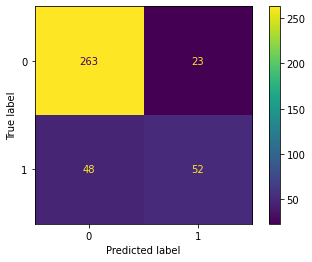

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

# Create a confusion matrix
conf_mat = confusion_matrix(test_labels, lista_predicho_label)

# Print the confusion matrix
print(conf_mat)

confusion_matrix = confusion_matrix(test_labels, lista_predicho_label)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(test_labels, lista_predicho_label)
precision = precision_score(test_labels, lista_predicho_label, average='macro')
recall = recall_score(test_labels, lista_predicho_label, average='macro')
f1 = f1_score(test_labels, lista_predicho_label, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

# Accuracy: 0.839
# Precision: 0.810
# Recall: 0.745
# F1 score: 0.768

Accuracy: 0.816
Precision: 0.769
Recall: 0.720
F1 score: 0.738


In [ ]:
# Accuracy: 0.816
# Precision: 0.769
# Recall: 0.720
# F1 score: 0.738

### Explicar con SHAP

In [76]:
import shap

In [77]:
linea_ = "i hate donald trump" 
linea_2 = "we need free healthcare or we are going to die" 

predict_input_1 = tokenizer_fine_tuned.encode(
    linea_,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

predict_input_2 = tokenizer_fine_tuned.encode(
    linea_2,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

In [78]:
output_1 = model_fine_tuned(predict_input_1)[0]

prediction_value_1 = tf.argmax(output_1, axis = 1).numpy()[0]
print(linea_)
prediction_value_1

# 0  es neutro 

i hate donald trump


1

In [79]:
output_2 = model_fine_tuned(predict_input_2)[0]

prediction_value_2 = tf.argmax(output_2, axis = 1).numpy()[0]
print(linea_2)
prediction_value_2
# 1 es partisan

we need free healthcare or we are going to die


1

Textos a usar son los textos que obtuvieron un score significativo

In [80]:
textos_para_shap = []
for i in lista_v2:
    texto_para_shap = test_texts[i]
    textos_para_shap.append(texto_para_shap)

In [81]:
# textos_para_shap

#### Creamos un pipeline con nuestro modelo para meterlo a SHAP

In [82]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

pipe = TextClassificationPipeline(model=model_fine_tuned, tokenizer=tokenizer_fine_tuned, 
                                  return_all_scores=True, device=0, )
print(pipe.device) ## El pipe no está en el GPU (por eso sale -1 (false) Pero si el model_fine_tuned y el tokenizer_fine_tuned)

0


In [83]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [84]:
len(textos_para_shap)

118

In [95]:
%%time

import time
time_1 = time.time()

Wall time: 0 ns


In [96]:
%%time

explainer = shap.Explainer(pipe)
shap_values = explainer(textos_para_shap)

  0%|                                                                                          | 0/498 [00:00<?, ?it/s]
504it [00:00, 4581.98it/s]                                                                                             
  0%|                                                                                          | 0/498 [00:00<?, ?it/s]
504it [00:00, 3937.57it/s]                                                                                             
 96%|███████████████████████████████████████████████████████████████████████████▌   | 476/498 [00:02<00:00, 131.49it/s]
500it [00:03, 126.11it/s]                                                                                              
Partition explainer: 119it [07:12,  3.73s/it]                                                                          

Wall time: 7min 12s


Algo que ocurre en la explciacion de SHAP, es que el modelo de cierta forma hace un "overfit" a algunas palabras como OBAMA, HEALTH y otras, sin detectr exactamente el contexto o la razon por la cual el *texto* es clasificado de una u otra forma. Esto tiene sentido ya que la data qu se tiene es de mala calidad.

In [91]:
time_2 = time.time()
print(time_2 - time_1)

447.987713098526


In [92]:
447.98/60

## Toma 7 minutos y 12 segundos cuando uso DEVICE=0 en el PIPELINE,
## Es mas caundo hago el print(pipe.device) sale device 0 (VREDADERO), osea esta usando o apoyandose en el GPU.

7.466333333333334

In [ ]:
## explainer sin permutation tomaba 45 min
## explainer con PERMUTATION toma 58 min

In [ ]:
# 20 54

# 40 min

In [206]:
# 0 neutro / 1 partisano
print(lista_v[120])

[0.6371502, 177]


In [207]:
print(lista_v3[120])

1


In [209]:
# En lista LABELS tenemos que poner como índice al índice que obtuvimos en lista_v, 
# porque ese índice es el índice de la predicción
# el nuevo índice va del 0 al 123, pero el antiguo va del 0 al 300+
test_labels[177]

0

In [210]:
# En lista SCORES tenemos que poner como índice al índice que obtuvimos en lista_v, 
# porque ese índice es el índice de la predicción
# el nuevo índice va del 0 al 123, pero el antiguo va del 0 al 300+
lista_scores[177]
## Verificar que sea el mayor % para 1 (partisan)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.3628497>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6371502>]

In [ ]:
# https://datascience.stackexchange.com/questions/113359/why-there-is-no-preprocessing-step-for-training-bert